<a href="https://colab.research.google.com/github/BrianArnesto/masterThesis/blob/main/Master_Thesis_Fake_News_Detection_of_Indonesian_Langguage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html
https://scikit-learn.org/stable/modules/sgd.html
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
https://github.com/leelaylay/TweetSemEval
https://towardsdatascience.com/yet-another-twitter-sentiment-analysis-part-1-tackling-class-imbalance-4d7a7f717d44
https://github.com/cbaziotis/datastories-semeval2017-task4


# Load the *library*

In [76]:
import requests
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive
from collections import Counter
import pycaret
from transformers import BertTokenizer, AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import torch.nn as nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


drive.mount('/content/drive')
# specify GPU
device = torch.device("cuda")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.72 s (started: 2023-01-10 10:22:16 +00:00)


#Install the required library

In [ ]:
!pip install -r /content/drive/MyDrive/thesis/requirements.txt

#Data Fetch 

In [ ]:
url = 'http://maps.googleapis.com/maps/api/directions/json'

params = dict(
    origin='Chicago,IL',
    destination='Los+Angeles,CA',
    waypoints='Joplin,MO|Oklahoma+City,OK',
    sensor='false'
)

resp = requests.get(url=url, params=params)
data = resp.json() # Check the JSON Response Content documentation below

print(data)

In [ ]:
url = 'https://yudistira.turnbackhoax.id/api/antihoax/'

headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'Accept': 'application/json'
}

body = {
    'key': '231b200cxb534x5c797a432dd30b0vc2',
    'limit': 1000
}

resp = requests.post(url=url, headers=headers, data=body)
data = resp.json()

print(data)

In [ ]:
len(data)

In [ ]:
#Get total number of dataset in mafindo server
url = 'https://yudistira.turnbackhoax.id/api/antihoax/get_total'
headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    'Accept': 'application/json'
}

body = {
    'key': '231b200cxb534x5c797a432dd30b0vc2'
}

resp = requests.post(url=url, headers=headers, data=body)
total = resp.json() # Check the JSON Response Content documentation below

print(total)

In [ ]:
def fetch_data(offset):
  url = 'https://yudistira.turnbackhoax.id/api/antihoax/'

  headers = {
      'Content-Type': 'application/x-www-form-urlencoded',
      'Accept': 'application/json'
  }

  body = {
      'key': '231b200cxb534x5c797a432dd30b0vc2',
      'limit': 1000,
      'offset': offset
  }

  resp = requests.post(url=url, headers=headers, data=body)
  data = resp.json()
  return data

data_list = []
offset = 0
for i in range(10):
  d = fetch_data(offset)
  offset += len(d)
  data_list += d
  # sleep(2)

print(len(data_list))

In [ ]:
data_list

In [ ]:
d = fetch_data(10000)
data_list += d

In [ ]:
data_list

In [ ]:
#Convert json dataset into pandas dataframe
df = pd.DataFrame.from_records(data_list)

In [ ]:
#export the dataset into csv in the google drive
df.to_csv('/content/drive/MyDrive/thesis/news.csv', sep='\t')

#Data Preprocessing

###Load the dataset

In [9]:
df = pd.read_csv('/content/drive/MyDrive/thesis/news.csv', sep='\t')

time: 2.34 s (started: 2023-01-10 10:03:49 +00:00)


###Load the Indonesian Langguage stopword

In [10]:
id_stopword_dict = pd.read_csv('/content/drive/MyDrive/thesis/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})

time: 223 ms (started: 2023-01-10 10:03:51 +00:00)


In [11]:
id_stopword_dict.head()

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak


time: 15.4 ms (started: 2023-01-10 10:03:51 +00:00)


###Load the Indonesian Slang Dataset

In [12]:
alay_dict = pd.read_csv('/content/drive/MyDrive/thesis/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

time: 271 ms (started: 2023-01-10 10:03:51 +00:00)


###Overview of the dataset

In [13]:
print("Shape: ", df.shape)
df.head(15)

Shape:  (10756, 16)


,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,"\nLiputan6.com, Jakarta - Kabar tentang artis ...",\nCek Fakta Liputan6.com menelusuri kabar tent...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,"\nLiputan6.com, Jakarta - Klaim tentang menemp...",\nCek Fakta Liputan6.com menelusuri klaim mene...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
2,2,10926,36,2,Misleading Content,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,Akun Facebook bernama TH K menyebarluaskan tau...,Setelah dilakukan penelusuran dengan Google Re...,https://www.cnnindonesia.com/nasional/20210426...,facebook.com,https://archive.cob.web.id/archive/1667651236....,https://turnbackhoax.id/wp-content/uploads/202...,NaN,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: teks, sc...",Hasil periksa fakta Evarizma Zahra.\r\n\r\nKon...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,"\nLiputan6.com, Jakarta - Sebuah video yang di...",\nCek Fakta Liputan6.com menelusuri video yang...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.co...",\nCek Fakta Liputan6.com menelusuri klaim vide...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
5,5,10923,36,2,Misleading Content,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,Akun Twitter dengan nama pengguna “uytimes” me...,"Berdasarkan hasil penelusuran, narasi tersebut...",https://www.douyin.com/video/70471093072544924...,twitter.com,https://archive.cob.web.id/archive/1667926200....,https://turnbackhoax.id/wp-content/uploads/202...,NaN,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: mixed, s...",Hasil Periksa Fakta Khairunnisa A.\r\n\r\nHoak...
6,6,10922,36,2,Misleading Content,[SALAH] Wanita berusia 399 Tahun,"""399 Years Women, Oldest woman in the world""\n...",Beredar video Tiktok yang diunggah oleh @bria...,https://turnbackhoax.id/2022/04/05/salah-video...,Tiktok,https://archive.cob.web.id/archive/1667920179....,https://turnbackhoax.id/wp-content/uploads/202...,NaN,2022-11-09,"Cek fakta, tbh, tema: unik, alat: mixed, SC: T...",Hasil Periksa Fakta Dyah Febriyani. Narasi dal...
7,7,10921,29,2,-,Cek Fakta: Tidak Benar Vaksin Genosida Uni Ero...,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.co...",\nCek Fakta Liputan6.com menelusuri klaim vaks...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512085...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-09,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
8,8,10920,29,2,-,Cek Fakta: Tidak Benar Mantan Presiden Soehart...,"\nLiputan6.com, Jakarta - Beredar di media sos...",\nCek Fakta Liputan6.com menelusuri dan menemu...,https://www.liputan6.com/news/read/5115252/jok...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512069...,https://cdn1-production-images-kly.akamaized.n...,NaN,2022-11

time: 38.9 ms (started: 2023-01-10 10:03:52 +00:00)


In [14]:
df.describe()

,Unnamed: 0,id,status
count,10756.000000,10756.000000,10756.000000
mean,5377.500000,5488.900149,2.128486
std,3105.134082,3152.556646,0.841311
min,0.000000,4.000000,0.000000
25%,2688.750000,2743.750000,2.000000
50%,5377.500000,5509.500000,2.000000
75%,8066.250000,8223.250000,2.000000
max,10755.000000,10928.000000,15.000000


time: 29.8 ms (started: 2023-01-10 10:03:52 +00:00)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10756 entries, 0 to 10755
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      10756 non-null  int64 
 1   id              10756 non-null  int64 
 2   authors         10337 non-null  object
 3   status          10756 non-null  int64 
 4   classification  10756 non-null  object
 5   title           10755 non-null  object
 6   content         10466 non-null  object
 7   fact            10553 non-null  object
 8   references      10694 non-null  object
 9   source_issue    10031 non-null  object
 10  source_link     7642 non-null   object
 11  picture1        10464 non-null  object
 12  picture2        1981 non-null   object
 13  tanggal         10756 non-null  object
 14  tags            10731 non-null  object
 15  conclusion      6571 non-null   object
dtypes: int64(3), object(13)
memory usage: 1.3+ MB
time: 31.2 ms (started: 2023-01-10 10:03:52 +00:

In [16]:
df['classification'].isnull().sum()

0

time: 5.61 ms (started: 2023-01-10 10:03:52 +00:00)


In [17]:
df['classification'].describe()

count                  10756
unique                    10
top       Misleading Content
freq                    2629
Name: classification, dtype: object

time: 17.3 ms (started: 2023-01-10 10:03:52 +00:00)


In [18]:
df['classification'].unique()

array(['-', 'Misleading Content', 'Fabricated Content',
       'Impostor Content', 'Manipulated Content', 'False Context',
       'Satire', 'False Connection', 'Clarification', 'TRUE'],
      dtype=object)

time: 6.66 ms (started: 2023-01-10 10:03:52 +00:00)


###Total count of each category

In [19]:
print(Counter(df['classification'].values))

Counter({'Misleading Content': 2629, 'False Context': 2234, '-': 1829, 'Fabricated Content': 1152, 'Manipulated Content': 1152, 'Impostor Content': 503, 'TRUE': 420, 'Clarification': 396, 'False Connection': 279, 'Satire': 162})
time: 2.63 ms (started: 2023-01-10 10:03:52 +00:00)


In [20]:
df.loc[df['classification'] == '-'] 
#to do 
#check the content

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,"\nLiputan6.com, Jakarta - Kabar tentang artis ...",\nCek Fakta Liputan6.com menelusuri kabar tent...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,"\nLiputan6.com, Jakarta - Klaim tentang menemp...",\nCek Fakta Liputan6.com menelusuri klaim mene...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,"\nLiputan6.com, Jakarta - Sebuah video yang di...",\nCek Fakta Liputan6.com menelusuri video yang...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.co...",\nCek Fakta Liputan6.com menelusuri klaim vide...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
7,7,10921,29,2,-,Cek Fakta: Tidak Benar Vaksin Genosida Uni Ero...,"\nLiputan6.com, Jakarta- Cek Fakta Liputan6.co...",\nCek Fakta Liputan6.com menelusuri klaim vaks...,NaN,liputan6.com,https://www.liputan6.com/cek-fakta/read/512085...,https://cdn0-production-images-kly.akamaized.n...,NaN,2022-11-09,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,10747,13,NaN,1,-,(EDUKASI) 7 Tipe Informasi Hoax,NaN,"Dari yang saya amati, “tema” pesan hoax biasan...",https://www.facebook.com/youthmanualid/posts/6...,NaN,SocialMedia,https://turnbackhoax.id/wp-content/uploads/201...,NaN,2018-04-29,"Tipe HOAX, cekfakta",NaN
10748,10748,12,NaN,2,-,[KLARIFIKASI] Foto Wagub DKI Sedang Berada di ...,https://turnbackhoax.id/wp-content/uploads/201...,1. Secara resmi dan sah Djarot beragama Islam\...,http://www.satuharapan.com/…/wagub-dki-sumbang...,facebook.com,NaN,https://turnbackhoax.id/wp-content/uploads/201...,NaN,2018-04-29,"Djarot, Kristen, cekfakta",NaN
10749,10749,11,NaN,2,-,[HOAX] Uang Bayaran dari Tim Basuki-Djarot,https://turnbackhoax.id/wp-content/uploads/201...,Foto berupa tiga lembar uang Rp. 100.000 denga...,https://www.facebook.com/groups/fafhh/permalin...,facebook.com,SocialMedia,https://turnbackhoax.id/wp-content/uploads/201...,NaN,2018-04-29,"Badja Uang, cekfakta",NaN
10750,10750,10,NaN,2,-,[DISINFORMASI] Perubahan Suara saat Hitungan K...,Perubahan suara pd saat hitungan KPU sdh 100%....,"“Iya, ada kesalahan input data, di TPS 10 Kelu...",https://www.facebook.com/groups/fafhh/permalin...,facebook.com,SocialMedia,https://turnbackhoax.id/wp-content/uploads/201...,NaN,2018-04-29,"Disinformasi, Anies - Sandi, KPU, cekfakta",NaN


time: 32.4 ms (started: 2023-01-10 10:03:52 +00:00)


###Preprocess the text data

In [21]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text):
    return stemmer.stem(text)

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa!!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("stemming: ", stemming("Perekonomian Indonesia sedang dalam pertumbuhan yang membanggakan"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))
print("remove_stopword: ", remove_stopword("ada hehe adalah huhu yang hehe"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
stemming:  ekonomi indonesia sedang dalam tumbuh yang bangga
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe
normalize_alay:  amin adik habis
remove_stopword:  hehe huhu hehe
time: 58.1 ms (started: 2023-01-10 10:03:52 +00:00)


In [22]:
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = stemming(text) # 4
    text = remove_stopword(text) # 5
    return text

time: 923 µs (started: 2023-01-10 10:03:52 +00:00)


In [23]:
df=df.astype(str)


time: 43.9 ms (started: 2023-01-10 10:03:52 +00:00)


In [24]:
df['content'] = df['content'].apply(preprocess)

time: 1min 9s (started: 2023-01-10 10:03:52 +00:00)


In [25]:
print("Shape: ", df.shape)
df.head(15)

Shape:  (10756, 16)


,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,liputan6 com jaka a kabar a is nikita mirzani ...,\nCek Fakta Liputan6.com menelusuri kabar tent...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,liputan6 com jaka a klaim tempel tepung beras ...,\nCek Fakta Liputan6.com menelusuri klaim mene...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
2,2,10926,36,2,Misleading Content,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,Setelah dilakukan penelusuran dengan Google Re...,https://www.cnnindonesia.com/nasional/20210426...,facebook.com,https://archive.cob.web.id/archive/1667651236....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: teks, sc...",Hasil periksa fakta Evarizma Zahra.\r\n\r\nKon...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,liputan6 com jaka a buah video klaim orang wan...,\nCek Fakta Liputan6.com menelusuri video yang...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,liputan6 com jaka a cek fakta liputan6 com kla...,\nCek Fakta Liputan6.com menelusuri klaim vide...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
5,5,10923,36,2,Misleading Content,[SALAH] Kebijakan Pemerintah Tiongkok yang Mew...,akun twitter nama uytimes unggah buah video ke...,"Berdasarkan hasil penelusuran, narasi tersebut...",https://www.douyin.com/video/70471093072544924...,twitter.com,https://archive.cob.web.id/archive/1667926200....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: mixed, s...",Hasil Periksa Fakta Khairunnisa A.\r\n\r\nHoak...
6,6,10922,36,2,Misleading Content,[SALAH] Wanita berusia 399 Tahun,399 years women oldest woman in the world terj...,Beredar video Tiktok yang diunggah oleh @bria...,https://turnbackhoax.id/2022/04/05/salah-video...,Tiktok,https://archive.cob.web.id/archive/1667920179....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-09,"Cek fakta, tbh, tema: unik, alat: mixed, SC: T...",Hasil Periksa Fakta Dyah Febriyani. Narasi dal...
7,7,10921,29,2,-,Cek Fakta: Tidak Benar Vaksin Genosida Uni Ero...,liputan6 com jaka a cek fakta liputan6 com kla...,\nCek Fakta Liputan6.com menelusuri klaim vaks...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512085...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-09,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
8,8,10920,29,2,-,Cek Fakta: Tidak Benar Mantan Presiden Soehart...,liputan6 com jaka a edar media sosial postinga...,\nCek Fakta Liputan6.com menelusuri dan menemu...,https://www.liputan6.com/news/read/5115252/jok...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512069...,https://cdn1-production-images-kly.akamaized.n...,nan,2022-11-09,"cekfakta, l

time: 26.2 ms (started: 2023-01-10 10:05:02 +00:00)


##Replace all '-' classification with false content


In [26]:
#Replace all '-' classification with false content
#df['classification'].replace('-', 'False Content', inplace=True)

time: 439 µs (started: 2023-01-10 10:05:02 +00:00)


In [27]:
df

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,liputan6 com jaka a kabar a is nikita mirzani ...,\nCek Fakta Liputan6.com menelusuri kabar tent...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,liputan6 com jaka a klaim tempel tepung beras ...,\nCek Fakta Liputan6.com menelusuri klaim mene...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
2,2,10926,36,2,Misleading Content,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,Setelah dilakukan penelusuran dengan Google Re...,https://www.cnnindonesia.com/nasional/20210426...,facebook.com,https://archive.cob.web.id/archive/1667651236....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: teks, sc...",Hasil periksa fakta Evarizma Zahra.\r\n\r\nKon...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,liputan6 com jaka a buah video klaim orang wan...,\nCek Fakta Liputan6.com menelusuri video yang...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,liputan6 com jaka a cek fakta liputan6 com kla...,\nCek Fakta Liputan6.com menelusuri klaim vide...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10751,10751,9,nan,2,-,[DISINFORMASI] Perlakuan Berbeda antara GNPF M...,gera nasional fatwa dana sedekah umat sumber p...,1. Teman Ahok pernah diperiksa KPK.\nLink : ht...,https://news.detik.com/berita/3312414/begini-a...,facebook.com,SocialMedia,https://turnbackhoax.id/wp-content/uploads/201...,nan,2018-04-29,"Disinformasi, GNPF MUI, TEMAN AHOK, cekfakta",nan
10752,10752,8,nan,1,TRUE,Pilot Garuda Berkata Rasis saat Petugas Bea Cu...,how about this indonesiagaruda racism on your ...,Pihak Garuda Indonesia langsung memberikan kla...,(1) http://megapolitan.kompas.com/read/2017/11...,twitter.com,nan,https://scontent-sit4-1.xx.fbcdn.net/v/t31.0-8...,https://scontent-sit4-1.xx.fbcdn.net/v/t31.0-8...,2017-11-21,"garudaindonesia, pilot, cina, sara, cekfakta",nan
10753,10753,7,nan,2,Fabricated Content,Surat Penetapan Pemberangkatan Haji Tahun 2018,surat berangkat haji 2018 hubung musim haji 20...,"Dirjen Penyelenggaraan Haji dan Umrah, Nizar A...",(1) http://www.galamedianews.com/haji/169468/k...,facebook.com,nan,https://scontent-sit4-1.xx.fbcdn.net/v/t31.0-8...,nan,2017-11-21,"haji, 2018, siskohaji, cekfakta",nan
10754,10754,5,nan,2,Fabricated Content,"""Ramai Berita SetNov Warga China Terus Datang""",ramai berita setya novanto warga bangsa cina d...,"""Faktanya Video yang diberikan oleh pemosting ...",https://youtu.be/YXeGUPoDEzM,facebook.com,nan,https://scontent-sit4-1.xx.fbcdn.net/v/t1.0-9/...,https://scontent-sit4-1.xx.fbcdn.net/v/t1.0-9/...,2018-11-21,"setnov, cina, wisatawan, komunis, kiamat, cekf...",nan


time: 24.9 ms (started: 2023-01-10 10:05:02 +00:00)


In [28]:
#List of True News but this is not published
len(df.loc[df['classification'] == 'TRUE'] )

420

time: 21.1 ms (started: 2023-01-10 10:05:02 +00:00)


In [29]:
df.loc[df['classification'] == 'TRUE']

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
1704,1704,9209,0,3,TRUE,Kolaborasi Cek Fakta Bersiap Antisipasi Hoaks ...,jejaring periksa fakta gawang asosiasi media s...,nan,nan,nan,nan,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-02-18,"berita, cekfakta",nan
5120,5120,5768,0,3,TRUE,CEK FAKTA: Benarkah Paslon KBS di Pilkada Beng...,ketua tim advokasi pasang calon abi bahrun her...,Berdasarkan penelusuran Tim Cek Fakta Bertuahp...,https://bertuahpos.com/cek-fakta/cek-fakta-ben...,Whatsapp.com,nan,https://bertuahpos.com/wp-content/uploads/2020...,nan,2020-12-09,"Whatsapp grup, ASN, PAslon KBS, cekfakta, pilk...",ahwa benar Tim Paslon Kasmarni-Bagus Santoso m...
5122,5122,5766,0,3,TRUE,Benarkah Suara Rekaman Fitnah JK Itu Milik Dan...,buah rekam video tuding figur jusuf kalla soso...,Berdasarkan hasil penelusuran tim Cek Fakta Ga...,https://galigo.id/detail/benarkah-suara-rekama...,Rekaman Suara,nan,https://portal.galigo.id/storage/news/16072436...,nan,2020-12-09,"Rekaman, danny pamanto, pilkada 2020, cekfakta",Berdasarkan pemeriksaan tim cek fakta Galigo.i...
5126,5126,5762,0,1,TRUE,"Cek Fakta: Benar, Cabup Barru Malkan Amin Meni...",media sosial chat whatsapp ramai kabar tinggal...,"Direktur RSUP Wahidin Sudirohusodo, dr Khalik ...",https://makassar.terkini.id/cek-fakta-benar-ca...,whatsapp.com,nan,https://makassar.terkini.id/aset/images/sites/...,nan,2020-12-09,"pilkada2020, cekfakta",nan
5127,5127,5761,0,1,TRUE,"[Cek Fakta] Arahkan Suara Pemilih, Anggota KPP...",edar informasi anggota kpps mungut suara 04 ca...,"Berdasarkan hasil cek fakta, adanya pemecatan ...",http://www.koranmerah.com/2020/12/09/cek-fakta...,facebook.com,nan,http://www.koranmerah.com/wp-content/uploads/2...,nan,2020-12-09,"Arahkan, Suara Pemilih, Anggota KPPS, Ampenan ...",nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10716,10716,65,nan,1,TRUE,[KLARIFIKASI] Penggalian Saluran Air di Penjar...,proyek gali salur air longsor makan korban jiw...,Dilansir dari akurat.co dan wartakota.tribunne...,http://news.akurat.co/id-213773-read-sandiaga-...,akurat.co,Media Daring,https://turnbackhoax.id/wp-content/uploads/201...,https://turnbackhoax.id/wp-content/uploads/201...,2018-05-03,"Klarifikasi, Galian Saluran Air, Sandiaga Uno,...",nan
10717,10717,64,13,1,TRUE,[KLARIFIKASI] FPI Tidak Menyebarkan Spanduk Ha...,front bela islam front bela islam ban pasang s...,Pihak Front Pembela Islam (FPI) membantah tela...,https://metro.sindonews.com/read/1302812/170/b...,nan,Media Daring,https://turnbackhoax.id/wp-content/uploads/201...,https://turnbackhoax.id/wp-content/uploads/201...,2018-05-04,"Klarifikasi, FPI, Habib Rizieq Shihab, Spanduk...",nan
10718,10718,62,nan,1,TRUE,[KLARIFIKASI] GUNUNG GONGGANG DI SAGARANTEN SU...,edar isu gunung gonggang sukabumi letus pasca ...,Gunung Gonggang yang memiliki ketinggian 691 m...,https://sukabumiupdate.com/detail/sukabumi/per...,nan,Media Daring,https://turnbackhoax.id/wp-content/uploads/201...,nan,2018-04-05,"Gunung Gonggang, cekfakta",nan
10719,10719,61,nan,1,TRUE,"[KLARIFIKASI] ""PT. Dirgantara Indonesia Tak Di...",laku telusur berita fakta 2017 manajer hukum h...,PT. Dirgantara Indonesia (PTDI) melalui akun m...,https://www.antaranews.com/berita/626557/kabar...,nan,https://twitter.com/officialptdi/status/991970...,https://turnbackhoax.id/wp-content/uploads/201...,https://turnbackhoax.id/wp-content/uploads/201...,2018-05-04,"Dirgantara, cekfakta",nan


time: 25 ms (started: 2023-01-10 10:05:02 +00:00)


In [30]:
df.head()

,Unnamed: 0,id,authors,status,classification,title,content,fact,references,source_issue,source_link,picture1,picture2,tanggal,tags,conclusion
0,0,10928,29,2,-,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,liputan6 com jaka a kabar a is nikita mirzani ...,\nCek Fakta Liputan6.com menelusuri kabar tent...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512206...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-11,"cekfakta, liputan6, cekfakta-liputan6",\nKabar tentang artis Nikita Mirzani meninggal...
1,1,10927,29,2,-,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,liputan6 com jaka a klaim tempel tepung beras ...,\nCek Fakta Liputan6.com menelusuri klaim mene...,nan,liputan6.com,https://www.liputan6.com/cek-fakta/read/512197...,https://cdn0-production-images-kly.akamaized.n...,nan,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nKlaim menempelkan adonan tepung beras di tub...
2,2,10926,36,2,Misleading Content,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,Setelah dilakukan penelusuran dengan Google Re...,https://www.cnnindonesia.com/nasional/20210426...,facebook.com,https://archive.cob.web.id/archive/1667651236....,https://turnbackhoax.id/wp-content/uploads/202...,nan,2022-11-10,"cekfakta, tbh, tema: kesehatan, alat: teks, sc...",Hasil periksa fakta Evarizma Zahra.\r\n\r\nKon...
3,3,10925,29,2,-,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,liputan6 com jaka a buah video klaim orang wan...,\nCek Fakta Liputan6.com menelusuri video yang...,https://www.thetealmango.com/latest/who-is-399...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512178...,https://cdn1-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6",\nVideo yang diklaim seorang wanita tertua di ...
4,4,10924,29,2,-,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,liputan6 com jaka a cek fakta liputan6 com kla...,\nCek Fakta Liputan6.com menelusuri klaim vide...,\nhttps://vanlifewanderer.com/2022/08/03/kens...,liputan6.com,https://www.liputan6.com/cek-fakta/read/512121...,https://cdn0-production-images-kly.akamaized.n...,https://cdn1-production-images-kly.akamaized.n...,2022-11-10,"cekfakta, liputan6, cekfakta-liputan6","\nHasil penelusuran Cek Fakta Liputan6.com, kl..."


time: 20.8 ms (started: 2023-01-10 10:05:02 +00:00)


##Remove null value from title, content and classification column

In [31]:
df = df.dropna(subset=['title', 'content','classification'])

time: 20.3 ms (started: 2023-01-10 10:05:02 +00:00)


In [32]:
df.isnull().sum()

Unnamed: 0        0
id                0
authors           0
status            0
classification    0
title             0
content           0
fact              0
references        0
source_issue      0
source_link       0
picture1          0
picture2          0
tanggal           0
tags              0
conclusion        0
dtype: int64

time: 25.8 ms (started: 2023-01-10 10:05:02 +00:00)


##Remove unecessary column


In [33]:
#Remove unecessary column
df = df[['title','content','source_issue','tanggal','classification']]
df

,title,content,source_issue,tanggal,classification
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,liputan6 com jaka a kabar a is nikita mirzani ...,liputan6.com,2022-11-11,-
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,liputan6 com jaka a klaim tempel tepung beras ...,liputan6.com,2022-11-10,-
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,facebook.com,2022-11-10,Misleading Content
3,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,liputan6 com jaka a buah video klaim orang wan...,liputan6.com,2022-11-10,-
4,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,liputan6 com jaka a cek fakta liputan6 com kla...,liputan6.com,2022-11-10,-
...,...,...,...,...,...
10751,[DISINFORMASI] Perlakuan Berbeda antara GNPF M...,gera nasional fatwa dana sedekah umat sumber p...,facebook.com,2018-04-29,-
10752,Pilot Garuda Berkata Rasis saat Petugas Bea Cu...,how about this indonesiagaruda racism on your ...,twitter.com,2017-11-21,TRUE
10753,Surat Penetapan Pemberangkatan Haji Tahun 2018,surat berangkat haji 2018 hubung musim haji 20...,facebook.com,2017-11-21,Fabricated Content
10754,"""Ramai Berita SetNov Warga China Terus Datang""",ramai berita setya novanto warga bangsa cina d...,facebook.com,2018-11-21,Fabricated Content


time: 17.8 ms (started: 2023-01-10 10:05:02 +00:00)


##Counting number of content of each category of classification

In [34]:
df.classification.value_counts()

Misleading Content     2629
False Context          2234
-                      1829
Fabricated Content     1152
Manipulated Content    1152
Impostor Content        503
TRUE                    420
Clarification           396
False Connection        279
Satire                  162
Name: classification, dtype: int64

time: 6.41 ms (started: 2023-01-10 10:05:02 +00:00)


In [35]:
#Change the classification to numerical format
le = preprocessing.LabelEncoder()
le.fit(df.classification)
df['label'] = le.transform(df.classification)
df

,title,content,source_issue,tanggal,classification,label
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,liputan6 com jaka a kabar a is nikita mirzani ...,liputan6.com,2022-11-11,-,0
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,liputan6 com jaka a klaim tempel tepung beras ...,liputan6.com,2022-11-10,-,0
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,facebook.com,2022-11-10,Misleading Content,7
3,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,liputan6 com jaka a buah video klaim orang wan...,liputan6.com,2022-11-10,-,0
4,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,liputan6 com jaka a cek fakta liputan6 com kla...,liputan6.com,2022-11-10,-,0
...,...,...,...,...,...,...
10751,[DISINFORMASI] Perlakuan Berbeda antara GNPF M...,gera nasional fatwa dana sedekah umat sumber p...,facebook.com,2018-04-29,-,0
10752,Pilot Garuda Berkata Rasis saat Petugas Bea Cu...,how about this indonesiagaruda racism on your ...,twitter.com,2017-11-21,TRUE,9
10753,Surat Penetapan Pemberangkatan Haji Tahun 2018,surat berangkat haji 2018 hubung musim haji 20...,facebook.com,2017-11-21,Fabricated Content,2
10754,"""Ramai Berita SetNov Warga China Terus Datang""",ramai berita setya novanto warga bangsa cina d...,facebook.com,2018-11-21,Fabricated Content,2


time: 21.3 ms (started: 2023-01-10 10:05:02 +00:00)


In [36]:
df

,title,content,source_issue,tanggal,classification,label
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,liputan6 com jaka a kabar a is nikita mirzani ...,liputan6.com,2022-11-11,-,0
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,liputan6 com jaka a klaim tempel tepung beras ...,liputan6.com,2022-11-10,-,0
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,facebook.com,2022-11-10,Misleading Content,7
3,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,liputan6 com jaka a buah video klaim orang wan...,liputan6.com,2022-11-10,-,0
4,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,liputan6 com jaka a cek fakta liputan6 com kla...,liputan6.com,2022-11-10,-,0
...,...,...,...,...,...,...
10751,[DISINFORMASI] Perlakuan Berbeda antara GNPF M...,gera nasional fatwa dana sedekah umat sumber p...,facebook.com,2018-04-29,-,0
10752,Pilot Garuda Berkata Rasis saat Petugas Bea Cu...,how about this indonesiagaruda racism on your ...,twitter.com,2017-11-21,TRUE,9
10753,Surat Penetapan Pemberangkatan Haji Tahun 2018,surat berangkat haji 2018 hubung musim haji 20...,facebook.com,2017-11-21,Fabricated Content,2
10754,"""Ramai Berita SetNov Warga China Terus Datang""",ramai berita setya novanto warga bangsa cina d...,facebook.com,2018-11-21,Fabricated Content,2


time: 24.4 ms (started: 2023-01-10 10:05:02 +00:00)


In [37]:
df['content'] = df['content'].replace("href", '')

time: 4.49 ms (started: 2023-01-10 10:05:02 +00:00)


In [71]:
remove_words = ['href', 'nbsp', 'nan','ldque', 'ldquo','rdquo','blank','noopener','rel','amp','watch','target','tag','archive','tag']
pat = r'\b(?:{})\b'.format('|'.join(remove_words))

time: 3.5 ms (started: 2023-01-10 10:17:41 +00:00)


In [65]:
pat

'\\b(?:href|nbsp|nan|ldque|ldquo|rdquo|blank|noopener|rel|amp|watch|target)\\b'

time: 4.04 ms (started: 2023-01-10 10:15:46 +00:00)


In [73]:
df['content'] = df['content'].str.replace(pat, '')

time: 164 ms (started: 2023-01-10 10:18:06 +00:00)


In [67]:
df.head()

,title,content,source_issue,tanggal,classification,label
0,Cek Fakta: Hoaks Kabar Nikita Mirzani Meningga...,liputan6 com jaka a kabar a is nikita mirzani ...,liputan6.com,2022-11-11,-,0
1,Cek Fakta: Tidak Benar Tepung Beras Bisa Mered...,liputan6 com jaka a klaim tempel tepung beras ...,liputan6.com,2022-11-10,-,0
2,[SALAH] Menkes Budi Gunadi Sadikin: “Diabetes ...,akun facebook nama k menyebarluaskan taut a ga...,facebook.com,2022-11-10,Misleading Content,7
3,Cek Fakta: Tidak Benar Video Wanita Tertua di ...,liputan6 com jaka a buah video klaim orang wan...,liputan6.com,2022-11-10,-,0
4,Cek Fakta: Tidak Benar Kondisi AS Terkena Damp...,liputan6 com jaka a cek fakta liputan6 com kla...,liputan6.com,2022-11-10,-,0


time: 16 ms (started: 2023-01-10 10:15:50 +00:00)


##Feature Importance

In [74]:
v = CountVectorizer(ngram_range=(1,1))
x = v.fit_transform(df['content'])
 
 
model=LogisticRegression()
model.fit(x,df['classification'])
 
#we are not getting the absolute value
feature_importance=pd.DataFrame({'feature':v.get_feature_names(),'feature_importance':model.coef_[0]})
feature_importance.sort_values('feature_importance',ascending=False).head(10)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,feature,feature_importance
20870,liputan6,2.203435
20442,layar,1.421802
23545,muat,1.388180
34065,tempo,1.331264
26834,ph,1.290951
19423,kompas,1.015981
20318,lantik,1.003341
14474,haid,0.994498
25773,palsu,0.993077
13633,gelar,0.962242


time: 18.2 s (started: 2023-01-10 10:18:08 +00:00)


#Exploratory Data Analysis

#Traditional Machine Learning

In [77]:
#Original Imbalanced Data
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(max_depth=2, random_state=0)
neigh = KNeighborsClassifier(n_neighbors=3)
gnb = GaussianNB()
pct = Perceptron(tol=1e-3, random_state=0)
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           ')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

time: 10.2 ms (started: 2023-01-10 10:22:26 +00:00)


##Linear regression

In [80]:
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])
lr_cv(5, df.content, df.classification, original_pipeline, 'macro')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.80409357 0.25       0.51955307 0.         0.35364042 0.94
 0.46226415 0.42820839 0.         0.45454545]
recall:    [0.75136612 0.0125     0.40434783 0.         0.53243848 0.46534653
 0.21304348 0.64068441 0.         0.05952381]
f1 score:  [0.77683616 0.02380952 0.45476773 0.         0.425      0.62251656
 0.29166667 0.51332826 0.         0.10526316]
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.77675841 0.16666667 0.54       0.         0.36214605 0.83823529
 0.48113208 0.41329857 0.         0.5       ]
recall:    [0.69398907 0.01265823 0.46956522 0.         0.54362416 0.56435644
 0.22173913 0.6026616  0.         0.03571429]
f1 score:  [0.73304473 0.02352941 0.50232558 0.         0.43470483 0.67455621
 0.30357143 0.49033256 0.         0.06666667]
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.82035928 0.5        0.56020942 0.         0.37637795 0.75862069
 0.47154472 0.40903388 0.         0.54545455]
recall:    [0.74863388 0.01265823 0.46521739 0.         0.53467562 0.43564356
 0.25217391 0.61977186 0.         0.07142857]
f1 score:  [0.78285714 0.02469136 0.50831354 0.         0.44177449 0.55345912
 0.3286119  0.49281935 0.         0.12631579]
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.75071633 0.33333333 0.57777778 0.         0.35825545 0.83636364
 0.48818898 0.41645244 0.         0.72727273]
recall:    [0.71584699 0.03797468 0.45021645 0.         0.51454139 0.46
 0.26839827 0.61714286 0.         0.0952381 ]
f1 score:  [0.73286713 0.06818182 0.50608273 0.         0.42240588 0.59354839
 0.34636872 0.49731389 0.         0.16842105]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.80062305 0.6        0.52808989 0.         0.37384615 0.82142857
 0.46601942 0.4136253  0.         0.5       ]
recall:    [0.70410959 0.03797468 0.40692641 0.         0.54484305 0.46
 0.20779221 0.64638783 0.         0.0952381 ]
f1 sc

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Oversampling

###Random Over Sampler

In [81]:
#Random Over Sampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr )
SMOTE_pipeline_lr = make_pipeline(tvec, SMOTE(random_state=777),lr)
SMOTE_pipeline_rf = make_pipeline(tvec, SMOTE(random_state=777),rf)
SMOTE_pipeline_neigh = make_pipeline(tvec, SMOTE(random_state=777),neigh)
SMOTE_pipeline_gnb = make_pipeline(tvec, SMOTE(random_state=777),gnb)
SMOTE_pipeline_pct = make_pipeline(tvec, SMOTE(random_state=777),pct)
SMOTE_pipeline_sgd = make_pipeline(tvec, SMOTE(random_state=777),sgd)



time: 102 ms (started: 2023-01-10 10:29:04 +00:00)


In [84]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
df_tfidf = tvec.fit_transform(df.content)
X_res, y_res = sm.fit_resample(df_tfidf, df.classification)
print('Distribution before SMOTE: {}'.format(Counter(df.classification)))
print('Distribution after SMOTE: {}'.format(Counter(y_res)))

Distribution before SMOTE: Counter({'Misleading Content': 2629, 'False Context': 2234, '-': 1829, 'Fabricated Content': 1152, 'Manipulated Content': 1152, 'Impostor Content': 503, 'TRUE': 420, 'Clarification': 396, 'False Connection': 279, 'Satire': 162})
Distribution after SMOTE: Counter({'-': 2629, 'Misleading Content': 2629, 'Fabricated Content': 2629, 'Impostor Content': 2629, 'Manipulated Content': 2629, 'False Context': 2629, 'Satire': 2629, 'False Connection': 2629, 'Clarification': 2629, 'TRUE': 2629})
time: 8.1 s (started: 2023-01-10 10:29:56 +00:00)


In [85]:
lr_cv(5, df.content, df.classification, ROS_pipeline, 'macro')

Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.83757962 0.21698113 0.48917749 0.2        0.43378995 0.65555556
 0.32793522 0.49466951 0.23529412 0.27894737]
recall:    [0.71857923 0.2875     0.49130435 0.18181818 0.42505593 0.58415842
 0.35217391 0.44106464 0.12121212 0.63095238]
f1 score:  [0.77352941 0.24731183 0.49023861 0.19047619 0.42937853 0.61780105
 0.33962264 0.46633166 0.16       0.38686131]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.81587302 0.25862069 0.47679325 0.06666667 0.4416476  0.60344828
 0.36134454 0.51715686 0.25       0.2372093 ]
recall:    [0.70218579 0.37974684 0.49130435 0.05357143 0.43176734 0.69306931
 0.37391304 0.40114068 0.1875     0.607

###SMOTE with Logistic Regression

In [87]:
#SMOTE with Logistic Regression
lr_cv(5, df.content, df.classification, SMOTE_pipeline_lr, 'macro')


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.80804954 0.2016129  0.48484848 0.13461538 0.44018059 0.62886598
 0.36714976 0.48336595 0.20833333 0.37142857]
recall:    [0.71311475 0.3125     0.48695652 0.12727273 0.43624161 0.6039604
 0.33043478 0.46958175 0.15151515 0.61904762]
f1 score:  [0.75761974 0.24509804 0.48590022 0.13084112 0.43820225 0.61616162
 0.34782609 0.47637416 0.1754386  0.46428571]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.79421222 0.203125   0.46218487 0.07272727 0.45012165 0.57983193
 0.3507109  0.4898374  0.24137931 0.30573248]
recall:    [0.67486339 0.32911392 0.47826087 0.07142857 0.41387025 0.68316832
 0.32173913 0.4581749  0.21875    0.5714

###SMOTE with Random Forest

In [88]:
#SMOTE with Random Forest
lr_cv(5, df.content, df.classification, SMOTE_pipeline_rf, 'macro')


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.72206304 0.16901408 0.36526946 0.05660377 0.35820896 0.45945946
 0.27586207 0.72340426 0.04054054 0.0705347 ]
recall:    [0.68852459 0.15       0.26521739 0.10909091 0.10738255 0.33663366
 0.03478261 0.06463878 0.36363636 0.73809524]
f1 score:  [0.7048951  0.1589404  0.30730479 0.07453416 0.16523236 0.38857143
 0.06177606 0.11867365 0.07294833 0.12876428]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.61138614 0.33333333 0.33043478 0.03278689 0.41860465 0.50549451
 0.06382979 0.625      0.03278689 0.07542857]
recall:    [0.67486339 0.15189873 0.33043478 0.03571429 0.08053691 0.45544554
 0.01304348 0.01901141 0.3125     0.785

###SMOTE with KNN

In [89]:
#SMOTE with KNN
lr_cv(5, df.content, df.classification, SMOTE_pipeline_neigh, 'macro')


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.43537415 0.07368421 0.36683417 0.07971014 0.34210526 0.26666667
 0.23509934 0.71428571 0.10588235 0.08982036]
recall:    [0.52459016 0.4375     0.3173913  0.2        0.05816555 0.67326733
 0.30869565 0.01901141 0.27272727 0.17857143]
f1 score:  [0.47583643 0.12612613 0.34032634 0.11398964 0.09942639 0.38202247
 0.26691729 0.03703704 0.15254237 0.11952191]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.41898148 0.06775701 0.33152174 0.07758621 0.35632184 0.20489297
 0.24904215 0.5        0.04575163 0.09933775]
recall:    [0.49453552 0.36708861 0.26521739 0.16071429 0.06935123 0.66336634
 0.2826087  0.01140684 0.21875    0.178

###SMOTE with Perceptron

In [90]:
#SMOTE with Perceptron
lr_cv(5, df.content, df.classification, SMOTE_pipeline_pct, 'macro')

Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.76519337 0.15517241 0.44888889 0.10526316 0.36596737 0.62068966
 0.25783972 0.43611584 0.13636364 0.1754386 ]
recall:    [0.7568306  0.1125     0.43913043 0.07272727 0.35123043 0.53465347
 0.32173913 0.48669202 0.09090909 0.11904762]
f1 score:  [0.76098901 0.13043478 0.44395604 0.08602151 0.35844749 0.57446809
 0.28626692 0.46001797 0.10909091 0.14184397]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.6247191  0.17241379 0.48128342 0.11111111 0.38916256 0.55462185
 0.27835052 0.41987179 0.14285714 0.23684211]
recall:    [0.75956284 0.12658228 0.39130435 0.08928571 0.35346756 0.65346535
 0.23478261 0.49809886 0.15625    0.107

###SMOTE with SGD

In [91]:
#SMOTE with SGD
lr_cv(5, df.content, df.classification, SMOTE_pipeline_sgd, 'macro')


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.71168831 0.17482517 0.46245059 0.12698413 0.42228739 0.51694915
 0.35353535 0.54455446 0.1372549  0.38345865]
recall:    [0.74863388 0.3125     0.50869565 0.29090909 0.32214765 0.6039604
 0.30434783 0.41825095 0.21212121 0.60714286]
f1 score:  [0.72969374 0.22421525 0.48447205 0.17679558 0.36548223 0.55707763
 0.3271028  0.47311828 0.16666667 0.47004608]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.68542199 0.21875    0.40569395 0.07462687 0.48       0.47260274
 0.3814433  0.50789474 0.14754098 0.39705882]
recall:    [0.73224044 0.35443038 0.49565217 0.17857143 0.32214765 0.68316832
 0.32173913 0.36692015 0.28125    0.6428

#Downsampling

In [92]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn import under_sampling as us

RUS_pipeline = make_pipeline(tvec, RandomUnderSampler(random_state=777),lr)
NM1_pipeline = make_pipeline(tvec, NearMiss(sampling_strategy='not minority', version = 1),lr)
NM2_pipeline = make_pipeline(tvec, NearMiss(sampling_strategy='not minority', version = 2),lr)
NM3_pipeline = make_pipeline(tvec, NearMiss(sampling_strategy='not minority', version = 3, n_neighbors_ver3=4),lr)

time: 5.95 ms (started: 2023-01-10 10:44:25 +00:00)


## RandomUnderSampler

In [94]:
lr_cv(5, df.content, df.classification, RUS_pipeline, 'macro')

Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.75796178 0.13270142 0.35748792 0.08928571 0.38297872 0.56410256
 0.2516129  0.46184739 0.05462185 0.18688525]
recall:    [0.65027322 0.35       0.32173913 0.27272727 0.16107383 0.65346535
 0.16956522 0.21863118 0.39393939 0.67857143]
f1 score:  [0.7        0.19243986 0.33867277 0.13452915 0.22677165 0.60550459
 0.2025974  0.29677419 0.09594096 0.29305913]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.77       0.14778325 0.41436464 0.09756098 0.39655172 0.51094891
 0.26428571 0.49042146 0.04379562 0.17981073]
recall:    [0.63114754 0.37974684 0.32608696 0.28571429 0.15436242 0.69306931
 0.16086957 0.24334601 0.375      0.678

##Near Miss

###Near Miss 1

In [95]:
lr_cv(5, df.content, df.classification, NM1_pipeline, 'macro')


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.86055777 0.10886076 0.33       0.07183908 0.38235294 0.41401274
 0.27472527 0.50549451 0.03100775 0.08429119]
recall:    [0.59016393 0.5375     0.14347826 0.45454545 0.05816555 0.64356436
 0.10869565 0.08745247 0.12121212 0.52380952]
f1 score:  [0.70016207 0.18105263 0.2        0.12406948 0.10097087 0.50387597
 0.15576324 0.14910859 0.04938272 0.14521452]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.83141762 0.09855072 0.5        0.07236842 0.46391753 0.39877301
 0.34862385 0.50961538 0.05109489 0.0867052 ]
recall:    [0.59289617 0.43037975 0.24347826 0.39285714 0.10067114 0.64356436
 0.16521739 0.10076046 0.21875    0.535

In [98]:
from collections import Counter

nm1 = NearMiss(sampling_strategy='not minority', version=1, n_neighbors_ver3=4)
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
df_tfidf = tvec.fit_transform(df.content)
X_res, y_res = nm1.fit_resample(df_tfidf, df.classification)
print('Distribution before NearMiss-1: {}'.format(Counter(df.classification)))
print('Distribution after NearMiss-1: {}'.format(Counter(y_res)))

Distribution before NearMiss-1: Counter({'Misleading Content': 2629, 'False Context': 2234, '-': 1829, 'Fabricated Content': 1152, 'Manipulated Content': 1152, 'Impostor Content': 503, 'TRUE': 420, 'Clarification': 396, 'False Connection': 279, 'Satire': 162})
Distribution after NearMiss-1: Counter({'-': 162, 'Clarification': 162, 'Fabricated Content': 162, 'False Connection': 162, 'False Context': 162, 'Impostor Content': 162, 'Manipulated Content': 162, 'Misleading Content': 162, 'Satire': 162, 'TRUE': 162})
time: 7.76 s (started: 2023-01-10 10:49:31 +00:00)


### Near Miss 2

In [100]:
lr_cv(5, df.content, df.classification, NM2_pipeline, 'macro')

Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.8372093  0.11295681 0.37305699 0.10087719 0.42346939 0.66666667
 0.22857143 0.52432432 0.06756757 0.11057692]
recall:    [0.59016393 0.425      0.31304348 0.41818182 0.18568233 0.57425743
 0.13913043 0.18441065 0.3030303  0.54761905]
f1 score:  [0.69230769 0.17847769 0.34042553 0.16254417 0.25816485 0.61702128
 0.17297297 0.27285513 0.11049724 0.184     ]
--------------------------------------------------
Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.71621622 0.1221374  0.38509317 0.06936416 0.34857143 0.51908397
 0.28235294 0.48809524 0.07638889 0.09129512]
recall:    [0.57923497 0.40506329 0.26956522 0.21428571 0.13646532 0.67326733
 0.20869565 0.15589354 0.34375    0.511

In [102]:
from collections import Counter

nm2 = NearMiss(sampling_strategy='not minority', version=2, n_neighbors_ver3=4)
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
df_tfidf = tvec.fit_transform(df.content)
X_res, y_res = nm2.fit_resample(df_tfidf, df.classification)
print('Distribution before NearMiss-2: {}'.format(Counter(df.classification)))
print('Distribution after NearMiss-2: {}'.format(Counter(y_res)))

Distribution before NearMiss-2: Counter({'Misleading Content': 2629, 'False Context': 2234, '-': 1829, 'Fabricated Content': 1152, 'Manipulated Content': 1152, 'Impostor Content': 503, 'TRUE': 420, 'Clarification': 396, 'False Connection': 279, 'Satire': 162})
Distribution after NearMiss-2: Counter({'-': 162, 'Clarification': 162, 'Fabricated Content': 162, 'False Connection': 162, 'False Context': 162, 'Impostor Content': 162, 'Manipulated Content': 162, 'Misleading Content': 162, 'Satire': 162, 'TRUE': 162})
time: 10.2 s (started: 2023-01-10 10:53:41 +00:00)


###Near Miss 3

In [105]:
import pprint
pprint(lr_cv(5, df.content, df.classification, NM3_pipeline, 'macro'))

/usr/local/lib/python3.8/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:177: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.         0.         0.19634146 0.04097453 0.         0.
 0.         0.         0.04428904 0.        ]
recall:    [0.         0.         0.7        0.67272727 0.         0.
 0.         0.         0.57575758 0.        ]
f1 score:  [0.         0.         0.30666667 0.07724426 0.         0.
 0.         0.         0.08225108 0.        ]
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:177: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.         0.         0.23031204 0.04731458 0.         0.
 0.         0.33663366 0.04794521 0.        ]
recall:    [0.         0.         0.67391304 0.66071429 0.         0.
 0.         0.25855513 0.4375     0.        ]
f1 score:  [0.         0.         0.34330011 0.08830549 0.         0.
 0.         0.29247312 0.08641975 0.        ]
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:177: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.         0.         0.39285714 0.03305785 0.         0.
 0.         0.         0.03954802 0.        ]
recall:    [0.         0.         0.19130435 0.78571429 0.         0.
 0.         0.         0.875      0.        ]
f1 score:  [0.         0.         0.25730994 0.06344629 0.         0.
 0.         0.         0.07567568 0.        ]
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:177: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.         0.         0.24257426 0.03456221 0.         0.47706422
 0.         0.         0.04460967 0.        ]
recall:    [0.         0.         0.21212121 0.80357143 0.         0.52
 0.         0.         0.75       0.        ]
f1 score:  [0.         0.         0.22632794 0.06627393 0.         0.49760766
 0.         0.         0.08421053 0.        ]
--------------------------------------------------


/usr/local/lib/python3.8/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:177: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


Misleading Content,  False Context,  False Content, Fabricated Content, Manipulated Content, Impostor Content, Clarification, False Connection, TRUE, Satire           
precision: [0.         0.         0.15377698 0.04107425 0.         0.
 0.         0.         0.05665025 0.        ]
recall:    [0.         0.         0.74025974 0.46428571 0.         0.
 0.         0.         0.6969697  0.        ]
f1 score:  [0.         0.         0.25465376 0.0754717  0.         0.
 0.         0.         0.1047836  0.        ]
--------------------------------------------------
accuracy: 9.90% (+/- 3.48%)
precision: 4.92% (+/- 2.13%)
recall: 20.04% (+/- 1.53%)
f1 score: 5.96% (+/- 2.03%)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: ignored

time: 1min 38s (started: 2023-01-10 10:55:20 +00:00)


In [ ]:
from collections import Counter

nm3 = NearMiss(sampling_strategy='not minority', version=3, n_neighbors_ver3=4)
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
df_tfidf = tvec.fit_transform(df.content)
X_res, y_res = nm3.fit_resample(df_tfidf, df.classification)
print('Distribution before NearMiss-3: {}'.format(Counter(df.classification)))
print('Distribution after NearMiss-3: {}'.format(Counter(y_res)))

#IndoBERT Fine Tuning

In [72]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

time: 4.45 ms (started: 2023-01-09 22:59:18 +00:00)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

time: 18.7 ms (started: 2023-01-09 22:59:20 +00:00)


##Splitting the Dataset

In [74]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='auto')


# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(df['content'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['classification'])
                                                                    

# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)


print("Size of training set: {}".format(len(train_text)))
print("Size of validation set: {}".format(len(val_text)))


Size of training set: 7529
Size of validation set: 1613
time: 139 ms (started: 2023-01-09 22:59:23 +00:00)


In [78]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('indobenchmark/indobert-base-p1')
tokenizer = BertTokenizerFast.from_pretrained('indobenchmark/indobert-base-p1')

time: 4.38 s (started: 2023-01-09 23:01:27 +00:00)


##Prepare Input Data

Text(0, 0.5, 'Number of texts')

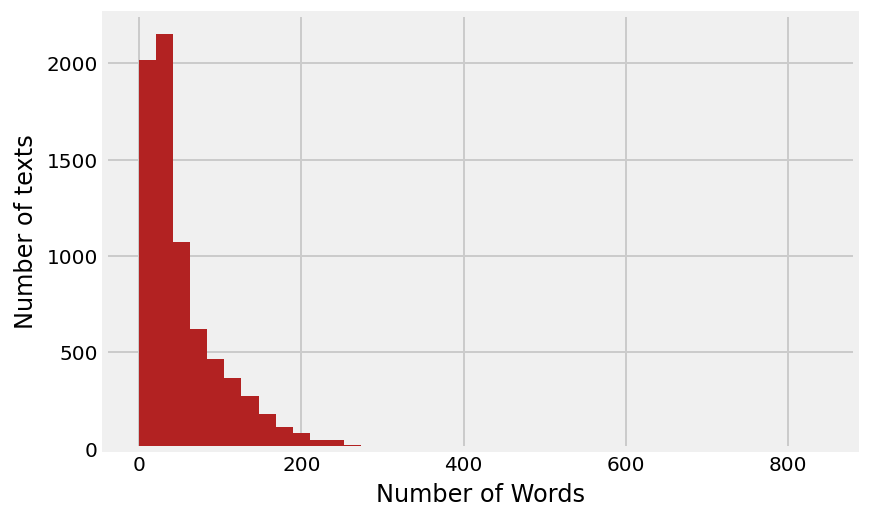

time: 379 ms (started: 2023-01-09 23:01:36 +00:00)


In [79]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [84]:
# BERT Tokeizer Functionality
sample_data = ["Build fake news model.", 
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[2, 25102, 1050, 30357, 4425, 1371, 30470, 3], [2, 29236, 533, 30470, 3, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0, 0]]}
time: 6.3 ms (started: 2023-01-09 23:01:41 +00:00)


In [81]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

time: 2.5 s (started: 2023-01-09 23:01:37 +00:00)


In [82]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

time: 31 ms (started: 2023-01-09 23:01:39 +00:00)


In [83]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

time: 1.95 ms (started: 2023-01-09 23:01:39 +00:00)


## Freeze Layers

In [56]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

time: 1.91 ms (started: 2023-01-09 09:20:01 +00:00)


## Define Model Architecture

In [57]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,10)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 5

time: 59.6 ms (started: 2023-01-09 09:20:01 +00:00)


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


time: 16.1 ms (started: 2022-11-14 21:45:40 +00:00)


##Define Train & Evaluate Function

In [58]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

time: 13.6 ms (started: 2023-01-09 09:20:01 +00:00)


## Model training

In [59]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/thesis/c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 2.058
Validation Loss: 1.944

 Epoch 2 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 1.933
Validation Loss: 1.913

 Epoch 3 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 1.909
Validation Loss: 1.900

 Epoch 4 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 1.893
Validation Loss: 1.884

 Epoch 5 / 5
  Batch    50  of    229.
  Batch   100  of    229.
  Batch   150  of    229.
  Batch   200  of    229.

Evaluating...

Training Loss: 1.882
Validation Loss: 1.870
time: 29min 53s (started: 2023-01-09 09:20:01 +00:00)


## Model performance

In [60]:
# load weights of best model
#path = '/content/drive/MyDrive/thesis/c1_fakenews_weights.pt'
#model.load_state_dict(torch.load(path))

time: 302 µs (started: 2023-01-09 09:49:54 +00:00)


In [61]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.40      0.49      0.44       267
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00       172
           3       0.00      0.00      0.00        42
           4       0.33      0.14      0.20       334
           5       0.00      0.00      0.00        75
           6       0.00      0.00      0.00       171
           7       0.27      0.75      0.39       393
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00        35

    accuracy                           0.30      1570
   macro avg       0.10      0.14      0.10      1570
weighted avg       0.21      0.30      0.22      1570

time: 57.1 s (started: 2023-01-09 09:49:54 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fake News Predictions

In [62]:
# # load weights of best model
# path = 'c1_fakenews_weights.pt'
# model.load_state_dict(torch.load(path))

time: 353 µs (started: 2023-01-09 09:50:51 +00:00)


In [63]:
# testing on unseen data
unseen_news_text = ["Video Presiden Joko Widodo Jenguk Lesti Kejora Di Rumah Sakit  Tanpa Kehadiran Rizky Billar",     # Fake
                    "mengapa satgasus dibubarkan setelah kasus Sambo Mencuat?",               # Fake
                    "Puluhan Orang Cidera Parah Gas Air Mata Hujani Masa Aksi 411 yang Sedang Sholat",           # Fake
                    "Muak Dengan Kelicikan Barat, Puluhan Kepala Negara Minta Jokowi Bentuk Sekaligus Pimpin PBB Baru"                          # Fake
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 200
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([7, 0, 7, 4])

time: 2.1 s (started: 2023-01-09 09:50:51 +00:00)


#Stance Detection

#Evidence Retreival

#Freeze the library and export to txt

In [ ]:
!pip freeze > /content/drive/MyDrive/thesis/requirements.txt